In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import fine_tunned_bert

import pandas as pd
import tensorflow as tf 

from tensorflow.keras import metrics 
import scikitplot as skplt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
# import scarcity labeled ads
df = pd.read_csv('data/scarcity_dataset.csv')
df

,ad,scarcity
0,it’s almost over the shortcut law that lets yo...,1
1,on sale this week sequel to nyt bestseller pro...,1
2,refugees are especially vulnerable to the dang...,1
3,we are motivating reminding and supporting vot...,1
4,the future of decentralized nomadic coliving i...,1
...,...,...
17995,parents take part in the study of the impact o...,0
17996,lincoln news lincoln mayor orders greater rest...,0
17997,joe biden beat the nra twice he got assault we...,0
17998,reid nearly lost his eye to cancer thanks to t...,0


In [8]:
bert_model_name='small_bert/bert_en_uncased_L-4_H-512_A-8'

In [9]:
# build test and training datasets 
cleaned_train, cleaned_test, y_train, y_test = train_test_split(df['ad'], df['scarcity'] , test_size = 0.2, random_state = 42 , shuffle = True)
cleaned_train, cleaned_val, y_train, y_val = train_test_split(cleaned_train, y_train,  test_size=0.25, random_state= 42, shuffle = True)

In [10]:
train_data = tf.data.Dataset.from_tensor_slices(  (cleaned_train,y_train) ).batch(32)
val_data = tf.data.Dataset.from_tensor_slices( (cleaned_val,y_val) ).batch(32)
test_data = tf.data.Dataset.from_tensor_slices( (cleaned_test,y_test) ).batch(32)

# create the fine_tunned_model
bert_model = fine_tunned_bert.create_fine_tunned_bert(train_data,bert_model_name=bert_model_name)

# training the model
history = bert_model.fit(x=train_data,epochs =5,validation_data = val_data,verbose=False)

# evaluation 
scores = bert_model.evaluate(test_data)
print("-----------------------------------------")
predictions=bert_model.predict(cleaned_test)
results = (predictions>0.5)*1
tn, fp, fn, tp = confusion_matrix(y_test,results).ravel()
print("Fold cofusion matrix")
print((tn, fp, fn, tp))
print("-----------------------------------------")


2022-06-02 17:50:28.460430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 17:50:29.127383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


113/113 [==============================] - 9s 79ms/step - loss: 0.1690 - accuracy: 0.9589 - precision: 0.9634 - recall: 0.9549 - auc: 0.9848
-----------------------------------------
113/113 [==============================] - 9s 73ms/step
Fold cofusion matrix
(1715, 66, 82, 1737)
-----------------------------------------


In [11]:
# model evaluation 
scores = bert_model.evaluate(test_data)
print("Accuracy: %.2f%%" % (scores[1]*100))

113/113 [==============================] - 9s 78ms/step - loss: 0.1690 - accuracy: 0.9589 - precision: 0.9634 - recall: 0.9549 - auc: 0.9848
Accuracy: 95.89%


In [12]:
print(metrics.classification_report(y_test, results, target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.95      0.96      0.96      1781
    scarcity       0.96      0.95      0.96      1819

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



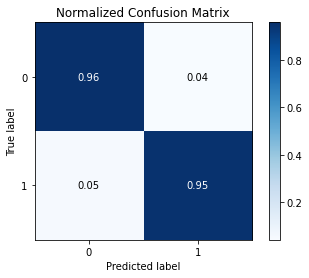

In [13]:
skplt.metrics.plot_confusion_matrix(y_test, results , normalize=True)
plt.show()

7/7 [==============================] - 0s 66ms/step
confusion matrix:
[[98  3]
 [25 73]]



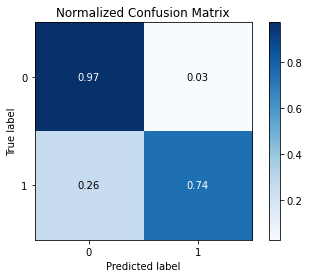

In [14]:
save = pd.read_csv('./data/sample_scarcity.csv')
test_data = tf.data.Dataset.from_tensor_slices( (save['ad'],save['scarcity']) ).batch(32)

pred_ =  bert_model.predict(save['ad'])
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()

In [15]:
print(metrics.classification_report(save['scarcity'], save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.80      0.97      0.87       101
    scarcity       0.96      0.74      0.84        98

    accuracy                           0.86       199
   macro avg       0.88      0.86      0.86       199
weighted avg       0.88      0.86      0.86       199

